In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sequence_jacobian.krusell_smith import household
from sequence_jacobian import utils
from scipy.optimize import brentq

In [2]:
household.inputs

{'Pi', 'a_grid', 'beta', 'e_grid', 'eis', 'r', 'w'}

In [3]:
e, pi, Pi = utils.markov_rouwenhorst(0.9, 0.9)
a_grid = utils.agrid(10_000, 300)

In [56]:
calib = dict(Pi=Pi, e_grid=e, a_grid=a_grid, eis=0.3,
             beta=0.95)
calib['eis'] = 0.2 # modify

In [57]:
beta=calib['beta']

# Part 1: given steady state object, solve for all terms in equation characterizing optimum

Equation that characterizes optimum is:

$$\frac{\lambda^{hh,e}}{\lambda^{hh,b_{-1}}}=\frac{1+\left(1-\beta(1+r)\right)\mathcal{E}_{b,\tau}}{1-\left(1-\beta(1+r)\right)\beta^{-1}\mathcal{E}_{\log b,r}}$$

where $\lambda^{hh,s}$ is endowment-weighted average marginal utility, $\lambda^{hh,b_{-1}}$ is incoming asset-weighted average marginal utility, $\mathcal{E}_{b,\tau}$ is the (two-sided) asymptotic response of aggregate household $b$ to $\tau$, aggregated with $\beta$ discounting, and $\mathcal{E}_{\log b,r}$ is the asymptotic response of aggregate $\log b$ to $r$, aggregated with $\beta$ discounting.

First, let's write function to solve for the $\mathcal{E}$s.

In [58]:
def ajac(ss, o, i, T=100):
    return household.ajac(ss, T, [i], [o], Tpost=T)[o.upper()][i].v 

In [59]:
def curlyE(ss, o, i, T=100):
    v = ajac(ss, o, i, T)
    return v @ (ss['beta']**(np.arange(2*T-1)-(T-1)))

Now write a function that gets this equation and all its constituents, given the ss. It's probably actually best to cross-multiply so that we don't get ratios that might blow up.

In [60]:
def stats(ss, T=100):
    E_b_tau = -curlyE(ss, 'a', 'w', T)
    E_logb_r = curlyE(ss, 'a', 'r', T) / ss['A']
    
    uc = ss['Va'] / (1+ss['r'])
    lambda_hh_e = np.einsum('sb,s,sb', uc, ss['e_grid'], ss['D'])
    lambda_hh_b = np.einsum('sb,b,sb', uc, ss['a_grid'], ss['D']) / ss['A']
    
    spread = 1 - ss['beta']*(1+ss['r'])
    
    left = lambda_hh_e * (1 - spread/ss['beta']*E_logb_r)
    right = lambda_hh_b * (1 + spread*E_b_tau)
  
    return left - right, E_b_tau, E_logb_r, lambda_hh_e, lambda_hh_b

# Part 2: write map from r and tau to asset market clearing and optimization error, then solve
Actually, I'm going to update this and no longer iterate over `tau`, because due to scaling it's irrelevant...

In [61]:
def get_ss(r, tau):
    return household.ss(**calib, r=r, w=1-tau, Va=1/((1-tau)*e[:, np.newaxis]+0.1*a_grid))

In [63]:
r = brentq(lambda r: stats(get_ss(r, 0))[0], -0.05, 1/calib['beta']-1-0.002)

In [64]:
ss = get_ss(r, 0)
rel_A = ss['A']
tau = r*rel_A / (1+r*rel_A)

In [65]:
r, tau

(-0.02321815135367408, -0.3996974671818631)

In [66]:
1/ss['beta']-1

0.05263157894736836

In [67]:
_, E_b_tau, E_logb_r, lambda_hh_e, lambda_hh_b = stats(ss)

In [68]:
E_b_tau

30.985941300999766

In [69]:
E_logb_r

-2.9884172980522745

In [70]:
lambda_hh_e / lambda_hh_b

2.635394865125411

Okay, interesting! So what we get is a *ton* of government debt, at 13 times income, so that almost two thirds of income needs to be taxed away to pay the debt.

Also interestingly (and I didn't really see this coming, nor do I understand it), the impact of taxes on debt, the $\mathcal{E}_{b,\tau}$, is just as big a deal as the impact of real interest rates, $\mathcal{E}_{\log b, r}$. This is because we save up to pay taxes?

I'm surprised that the difference in average marginal utility between income-weighted and bond-weighted is as small as it is. Perhaps that's because everyone is so satiated with bond wealth?

# What do the asymptotic jacobians look like?

In [71]:
T = 300

First the effect of an $r$ shock.

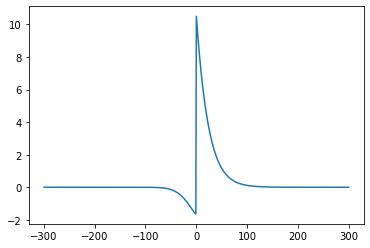

In [72]:
plt.plot(np.arange(-T+1, T), ajac(ss, 'a', 'r', T));

Use discounting thing.

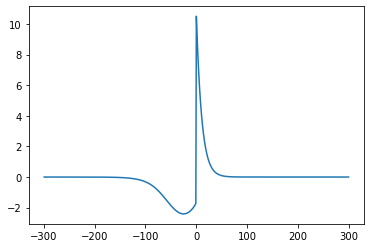

In [73]:
plt.plot(np.arange(-T+1, T), ajac(ss, 'a', 'r', T)*(ss['beta']**(np.arange(2*T-1)-(T-1))));

What about the effect of taxes (inverse of wages)?

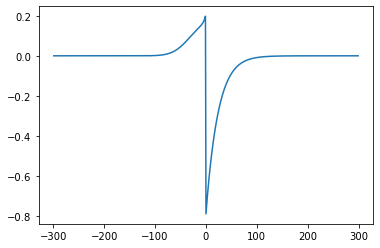

In [74]:
plt.plot(np.arange(-T+1, T), -ajac(ss, 'a', 'w', T));

Now with the discounting thing added.

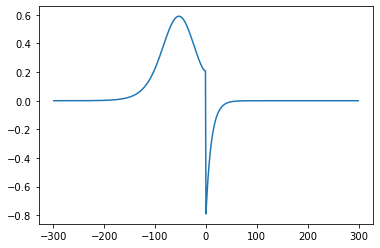

In [75]:
plt.plot(np.arange(-T+1, T), -ajac(ss, 'a', 'w', T)*(ss['beta']**(np.arange(2*T-1)-(T-1))));

# Coming back and exploring a little bit

Let's plot things with respect to $r$ to see what happens in light of our expression!

In [76]:
def stuff(r, eis):
    calib2 = {**calib, 'eis': eis}
    ss = household.ss(**calib2, r=r, w=1, Va=1/(e[:, np.newaxis]+0.1*a_grid))
    return (ss['A'], *stats(ss)[1:])

In [85]:
rs = np.array([-0.05, -0.03, -0.01, 0, 0.01, 0.02, 0.03, 0.04, 0.045, 0.048, 0.05])

In [92]:
eis = 1

In [93]:
As, E_b_taus, E_logb_rs, lambda_hh_es, lambda_hh_bs = map(np.array,zip(*[stuff(r, eis) for r in rs]))

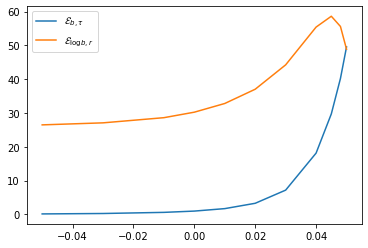

In [94]:
plt.plot(rs, E_b_taus, label=r'$\mathcal{E}_{b,\tau}$')
plt.plot(rs, E_logb_rs, label=r'$\mathcal{E}_{\log b, r}$')
plt.legend();

In [95]:
rightside = (1+(1-beta*(1+r))*E_b_taus)/(1-(1-beta*(1+r))/beta*E_logb_rs)
rightside

array([-1.00063562, -0.96586915, -0.89079503, -0.82684217, -0.75372838,
       -0.68324368, -0.64374211, -0.71986558, -0.9114187 , -1.21106939,
       -1.68842897])

In [96]:
leftside = lambda_hh_es / lambda_hh_bs
leftside

array([1.94283137, 1.76231553, 1.60131241, 1.53040916, 1.4662264 ,
       1.40850578, 1.35912711, 1.32106274, 1.31069069, 1.31018933,
       1.31565858])

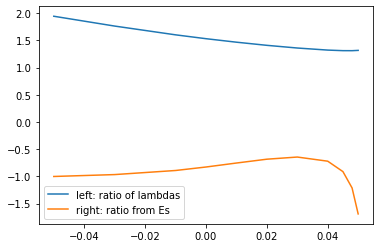

In [97]:
plt.plot(rs, leftside, label='left: ratio of lambdas')
plt.plot(rs, rightside, label='right: ratio from Es')
plt.legend();

So basically, the ratio on the right goes up as the response to taxes skyrockets, and the ratio on the left falls as saturation of assets makes the distribution more equal?

Oh snap, for eis=0.8 there are two intersections, that's awkward! Huh, there are multiple intersections in a lot of cases, it seems? Weird. But what is going on with my code? It seems to depend on the order in which it's run a bit?